# Regression model

This notebook models the data.

References<br />
Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.<br />
https://github.com/fonnesbeck/multilevel_modeling

#### Import statements

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

In [71]:
from pymc3 import glm, Model, NUTS, sample, forestplot, traceplot, summary, Normal, Uniform
from statsmodels.formula.api import ols

#### Variable definitions

In [4]:
data_filepath = "/Users/Jake/Desktop/innsbruck_dataset/all.csv"

## Load data

In [5]:
data = pd.read_csv(data_filepath).set_index('sound')
data = data.loc[data.site<=30]

## Plot data

Let's first look at a pairwise plot of a subset of the data.

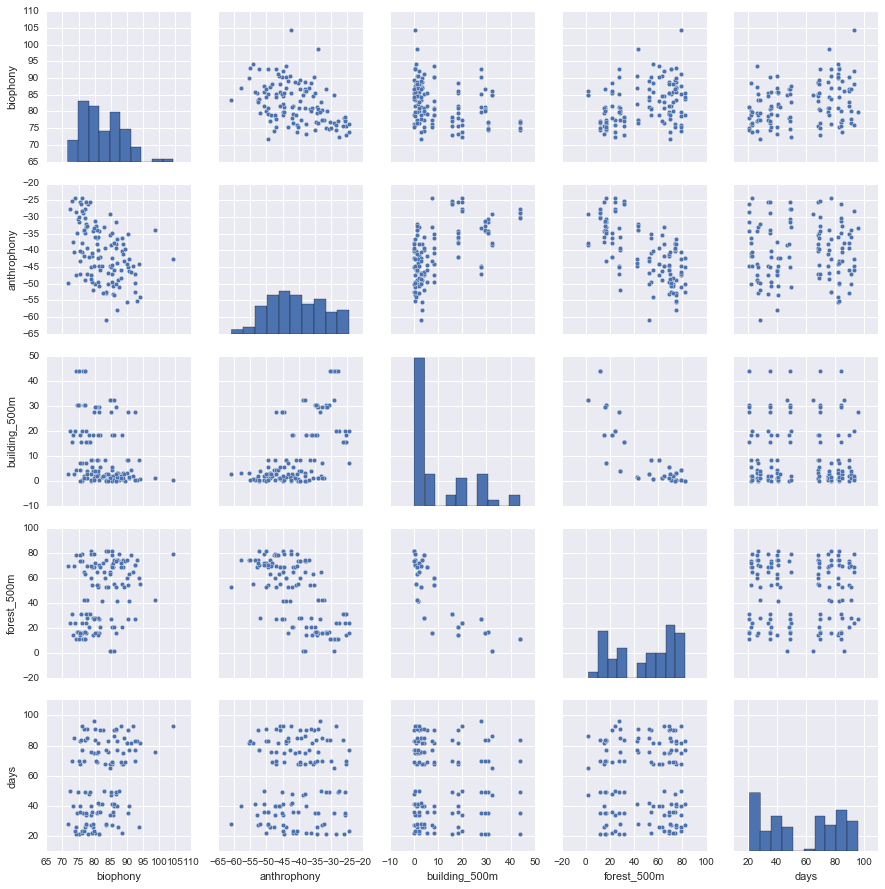

In [6]:
pairplot = seaborn.pairplot(data[['biophony', 'anthrophony', 'building_500m', 'forest_500m', 'days']])

/Users/Jake/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


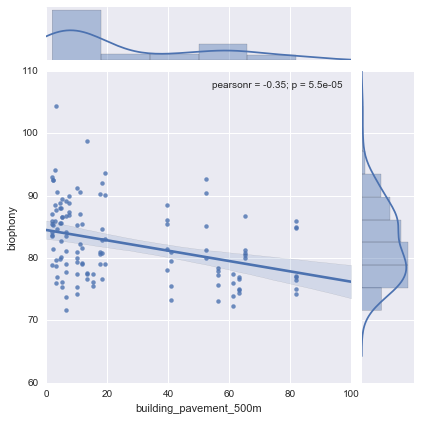

In [135]:
biophony_jointplot = seaborn.jointplot('building_pavement_500m', 'biophony', data=data, kind='reg', 
                                       xlim=(0, 100), ylim=(60, 110))

/Users/Jake/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


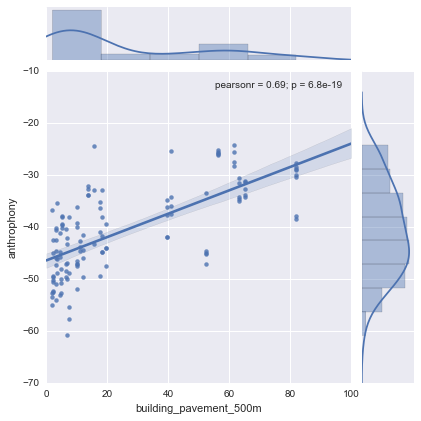

In [136]:
anthrophony_jointplot = seaborn.jointplot('building_pavement_500m', 'anthrophony', data=data, kind='reg', 
                                          xlim=(0, 100), ylim=(-70, -10))

As the boxplots show, repeated measurements of anthrophony and biophony varry little at some sites and greatly at others.

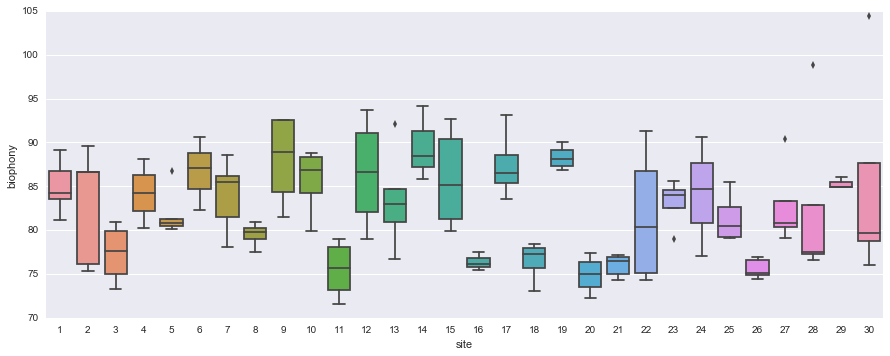

In [116]:
biophony_boxplot = seaborn.boxplot('site', 'biophony', data=data)
biophony_boxplot.figure.set_figwidth(15)

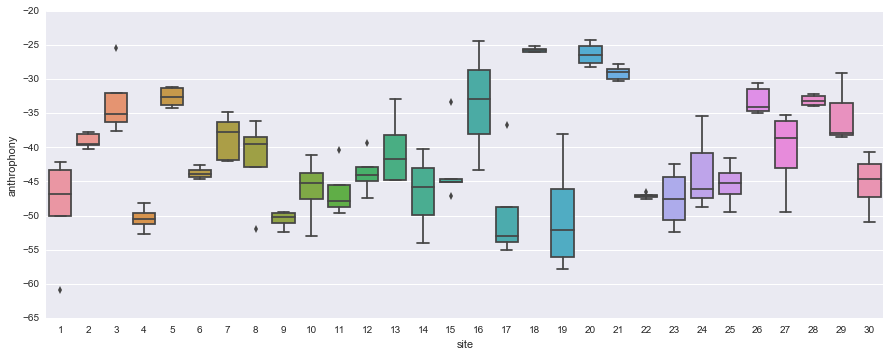

In [10]:
anthrophony_boxplot = seaborn.boxplot('site', 'anthrophony', data=data)
anthrophony_boxplot.figure.set_figwidth(15)

## Complete pooling

$$y_i = \beta_0 + \beta_1X_i$$

In [11]:
with Model() as pooled_model:
    glm.glm("biophony ~ days", data)
    pooled_trace = sample(1000, NUTS())

100%|██████████| 1000/1000 [00:02<00:00, 446.32it/s]


In [12]:
intercept0 = pooled_trace['Intercept'][500:].mean()
slope0 = pooled_trace['days'][500:].mean()

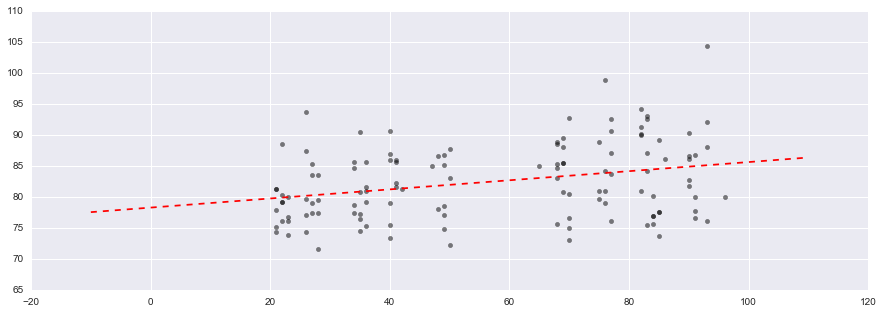

In [129]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.scatter(data.days, data.biophony, marker='o', color='black', alpha=0.5)
x_days = np.linspace(-10, 110)
ax.plot(x_days, intercept0 + slope0*x_days, 'r--')
ax.set_xlabel = "time (days from project start)"
ax.set_xlabel = "biophony"

## No pooling

$$y_{ij} = \beta_{0j} + \beta_{1j}X_{ij}$$

NOTE: something is off with the ols calculation

In [14]:
unpooled_fit = ols('biophony ~ C(site) * days - 1', data).fit()
unpooled_estimates = unpooled_fit.params

In [72]:
#unpooled_estimates = unpooled_estimates.rename(dict(zip(unpooled_estimates.index.values, 
#                    [x[10:-1] or x for x in unpooled_estimates.index.values])))
#unpooled_se = unpooled_fit.HC3_se.rename(dict(zip(unpooled_fit.HC3_se.index.values, 
#                    [x[10:-1] or x for x in unpooled_fit.HC3_se.index.values])))

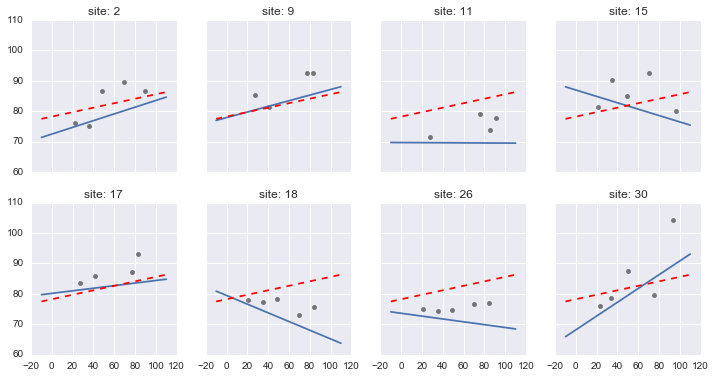

In [16]:
sample_sites = (2, 9, 11, 15, 17, 18, 26, 30)

fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
ax = ax.ravel()
for i, site in enumerate(sample_sites):
    y = data.biophony[data.site==site]
    x = data.days[data.site==site]
    ax[i].scatter(x + np.random.randn(len(x))*0.01, y, color='black', alpha=0.5)
    
    # No pooling model
    m, b = unpooled_estimates[['C(site)[T.{0}]:days'.format(site), 'C(site)[{0}]'.format(site)]]
    
    # Plot both models and data
    xvals = np.linspace(-10, 110)
    ax[i].plot(xvals, (m * xvals) + b)
    ax[i].plot(xvals, (slope0 * xvals) + intercept0, 'r--')
    ax[i].set_title("site: {0}".format(site))

## Partial pooling (empty model)

$$y_{ij} = \beta_{0j} + r_{ij}$$
$$\beta_{0j} = \gamma_{00} + u_{0j}$$

In [19]:
sites = np.copy(data.site.values) - 1

In [167]:
#sites_lookup = dict()
#for i, s in enumerate(set(sites)):
#    sites_lookup["{0}".format(s)] = i

In [169]:
#sites_index = np.empty_like(sites)
#for i, site in enumerate(sites):
#    sites_index[i] = sites_lookup[str(site)]

In [24]:
with Model() as partial_pooling:
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites]
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data.biophony.values)

In [25]:
with partial_pooling:
    step = NUTS()
    partial_pooling_samples = sample(2000, step)

100%|██████████| 2000/2000 [00:05<00:00, 353.76it/s]


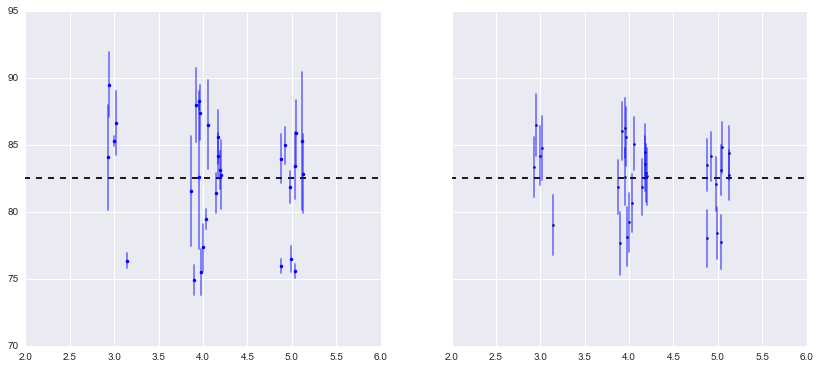

In [59]:
sample_trace = partial_pooling_samples['a'][-1000:]

fig, ax = plt.subplots(1, 2, figsize=(14,6), sharex=True, sharey=True)
samples, sites = sample_trace.shape
jitter = np.random.normal(scale=0.1, size=sites)

n_site = data.groupby('site')['biophony'].count()
unpooled_means = data.groupby('site')['biophony'].mean()
unpooled_sd = data.groupby('site')['biophony'].std()
unpooled = pd.DataFrame({'n':n_site, 'm':unpooled_means, 'sd':unpooled_sd})
unpooled['se'] = unpooled.sd/np.sqrt(unpooled.n)

ax[0].plot(unpooled.n + jitter, unpooled.m, 'b.')
for j, row in zip(jitter, unpooled.iterrows()):
    name, dat = row
    ax[0].plot([dat.n+j,dat.n+j], [dat.m-dat.se, dat.m+dat.se], 'b-', alpha=0.5)
ax[0].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')

samples, sites = sample_trace.shape
means = sample_trace.mean(axis=0)
sd = sample_trace.std(axis=0)
ax[1].scatter(n_site.values + jitter, means, marker='.')
ax[1].set_xlim(2, 6)
ax[1].hlines(sample_trace.mean(), 0.9, 100, linestyles='--')
for j,n,m,s in zip(jitter, n_site.values, means, sd):
    ax[1].plot([n+j]*2, [m-s, m+s], 'b-', alpha=0.5)

## Varying intercepts

$$y_{ij} = \beta_{0j} + \beta_{1j}X_{ij} + r_{ij}$$
$$\beta_{0j} = \gamma_{00} + u_{0j}$$
$$\beta_{1j} = \gamma_{10}$$

In [65]:
sites = np.copy(data.site.values) - 1

In [66]:
with Model() as varying_intercept:
    
    # Priors
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    # Common slope
    b = Normal('b', mu=0., tau=0.0001)
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites] + b * data.days.values
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data.biophony.values)

In [67]:
with varying_intercept:
    step = NUTS()
    varying_intercept_samples = sample(2000, step)

100%|██████████| 2000/2000 [00:03<00:00, 555.99it/s]


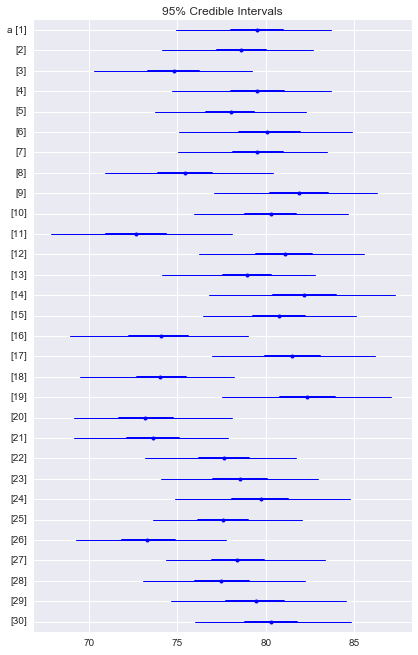

In [68]:
plt.figure(figsize=(6,10))
forestplot(varying_intercept_samples, varnames=['a'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d740358>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12dd985c0>]], dtype=object)

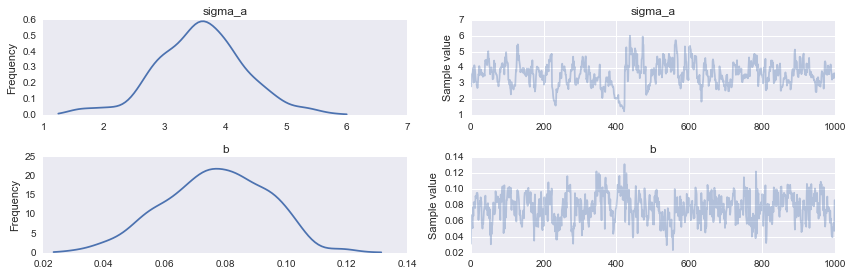

In [69]:
traceplot(varying_intercept_samples[-1000:], varnames=['sigma_a', 'b'])

In [72]:
summary(varying_intercept_samples[-1000:], varnames=['b'])


b:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.077            0.017            0.001            [0.045, 0.107]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.042          0.065          0.078          0.089          0.106



(-10, 110)

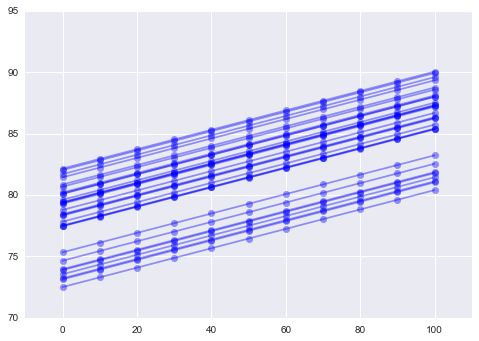

In [79]:
xvals = np.arange(0, 110, 10)
bp = varying_intercept_samples['a'].mean(axis=0)
mp = varying_intercept_samples['b'].mean()
for bi in bp:
    plt.plot(xvals, mp*xvals + bi, 'bo-', alpha=0.4)
plt.xlim(-10, 110)

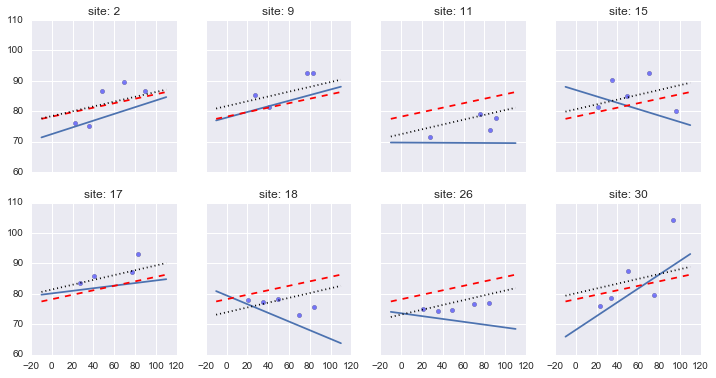

In [83]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
ax = ax.ravel()
for i, site in enumerate(sample_sites):
    
    # Plot county data
    y = data.biophony[data.site==site]
    x = data.days[data.site==site]
    ax[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.5)
    
    # No pooling model
    m, b = unpooled_estimates[['C(site)[T.{0}]:days'.format(site), 'C(site)[{0}]'.format(site)]]
    
    xvals = np.linspace(-10, 110)
    # Unpooled estimate
    ax[i].plot(xvals, m*xvals+b)
    # Pooled estimate
    ax[i].plot(xvals, slope0*xvals+intercept0, 'r--')
    # Partial pooling esimate
    ax[i].plot(xvals, mp*xvals+bp[site-1], 'k:')
    ax[i].set_title("site: {0}".format(site))

# Varying slope

$$y_{ij} = \beta_{0j} + \beta_{1j}X_{ij} + r_{ij}$$
$$\beta_{0j} = \gamma_{00}$$
$$\beta_{1j} = \gamma_{10} + u_{1j}$$

In [85]:
sites = np.copy(data.site.values) - 1

In [86]:
with Model() as varying_slope:
    
    # Priors
    mu_b = Normal('mu_b', mu=0., tau=0.0001)
    sigma_b = Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    
    # Model intercept
    a = Normal('a', mu=0., tau=0.0001)
    # Random slopes
    b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a + b[sites] * data.days.values
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data.biophony.values)

In [87]:
with varying_slope:
    step = NUTS()
    varying_slope_samples = sample(2000, step)

100%|██████████| 2000/2000 [01:39<00:00, 20.18it/s]


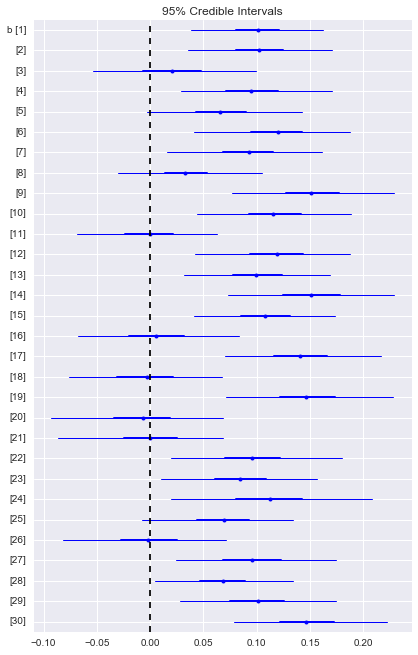

In [103]:
plt.figure(figsize=(6,10))
forestplot(varying_slope_samples, varnames=['b'])

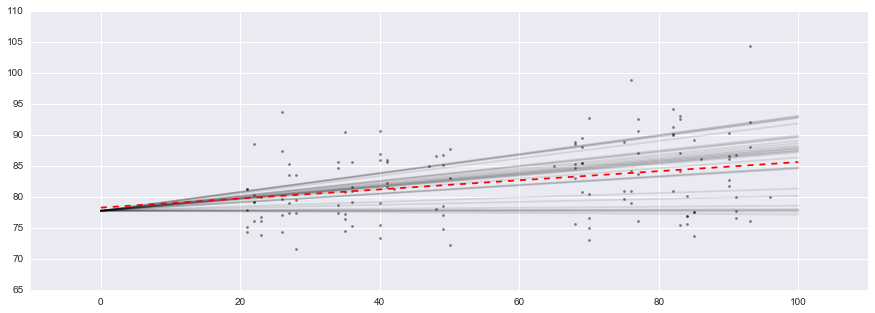

In [110]:
fig, ax = plt.subplots(figsize=(15, 5))

# all data
ax.scatter(data.days, data.biophony, marker='.', color='black', alpha=0.5)

# varying slopes
x_days = np.arange(0, 110, 100)
b = varying_slope_samples['a'].mean()
m = varying_slope_samples['b'].mean(axis=0)
for mi in m:
    ax.plot(x_days, mi*x_days + b, marker=None, color='black', alpha=0.1)
ax.set_xlim(-10, 110)

# pooled
plt.plot(x_days, intercept0 + slope0*x_days, marker=None, color='red', linestyle='--')

## Varying slope and intercept

$$y_{ij} = \beta_{0j} + \beta_{1j}X_{ij} + r_{ij}$$
$$\beta_{0j} = \gamma_{00} + u_{0j}$$
$$\beta_{1j} = \gamma_{10} + u_{1j}$$

In [ ]:
sites = np.copy(data.site.values) - 1

In [93]:
with Model() as varying_intercept_slope:
    
    # Priors    
    mu_a = Normal('mu_a', mu=0., tau=0.0001)
    sigma_a = Uniform('sigma_a', lower=0, upper=100)
    tau_a = sigma_a**-2
    
    mu_b = Normal('mu_b', mu=0., tau=0.0001)
    sigma_b = Uniform('sigma_b', lower=0, upper=100)
    tau_b = sigma_b**-2
    
    # Random intercepts
    a = Normal('a', mu=mu_a, tau=tau_a, shape=len(set(sites)))
    # Random slopes
    b = Normal('b', mu=mu_b, tau=tau_b, shape=len(set(sites)))
    
    # Model error
    sigma_y = Uniform('sigma_y', lower=0, upper=100)
    tau_y = sigma_y**-2
    
    # Expected value
    y_hat = a[sites] + b[sites] * data.days.values
    
    # Data likelihood
    y_like = Normal('y_like', mu=y_hat, tau=tau_y, observed=data.biophony.values)

In [94]:
with varying_intercept_slope:
    step = NUTS()
    varying_intercept_slope_samples = sample(2000, step)

100%|██████████| 2000/2000 [03:21<00:00,  9.92it/s]


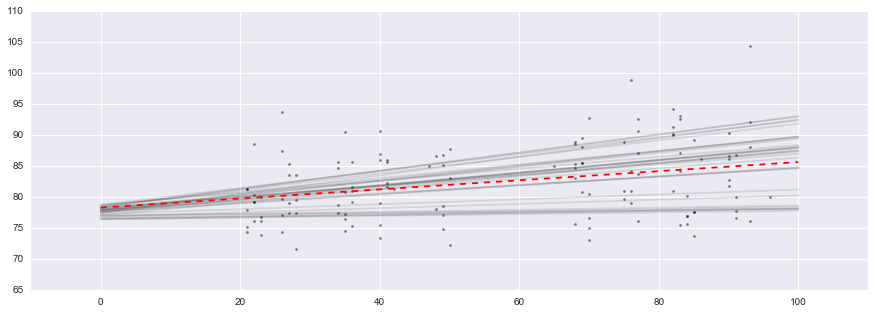

In [124]:
fig, ax = plt.subplots(figsize=(15, 5))

# all data
ax.scatter(data.days, data.biophony, marker='.', color='black', alpha=0.5)

# varying slopes
x_days = np.arange(0, 110, 100)
b = varying_intercept_slope_samples['a'].mean(axis=0)
m = varying_intercept_slope_samples['b'].mean(axis=0)
for bi,mi in zip(b,m):
    ax.plot(xvals, mi*xvals + bi, marker=None, color='black', alpha=0.1)
ax.set_xlim(-10, 110)

# pooled
plt.plot(x_days, intercept0 + slope0*x_days, marker=None, color='red', linestyle='--')

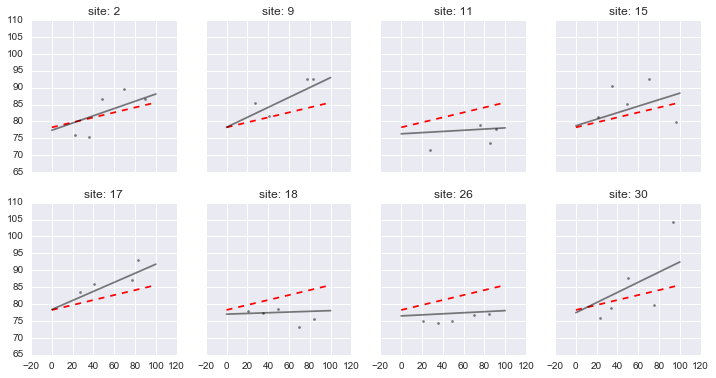

In [115]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
ax = ax.ravel()
for i, site in enumerate(sample_sites):
    
    # plot site data
    y = data.biophony[data.site==site]
    x = data.days[data.site==site]
    ax[i].scatter(x + np.random.randn(len(x))*0.01, y, color='black', marker='.', alpha=0.5)
    
    # pooled estimate
    ax[i].plot(xvals, slope0*xvals+intercept0, 'r--')
    # partial pooling esimate
    ax[i].plot(xvals, m[site-1]*xvals+b[site-1], 'k', alpha=0.5)
    ax[i].set_title("site: {0}".format(site))

## Model 3

$$y_{ij} = \beta_{0j} + \beta_{1j}X_1 + \beta_{2j}X_2 + \epsilon_{ij}$$
$$\beta_{0j} = \gamma_{00} + u_{0j}$$
$$\beta_{1j} = \gamma_{10}$$
$$\beta_{2j} = \gamma_{20} + u_{2j}$$